<a href="https://colab.research.google.com/github/mervegb/vacation-preference-prediction/blob/main/optimizing_travel_packages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
jahnavipaliwal_mountains_vs_beaches_preference_path = kagglehub.dataset_download('jahnavipaliwal/mountains-vs-beaches-preference')

print('Data source import complete.')


As a travel company aiming to boost business growth, we seek to enhance and personalize our travel packages while optimizing our marketing strategy. Using customer demographics, travel habits, and preferences, our goal is to identify target audiences and adjust offerings to increase engagement and bookings.

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import sqlite3 #for querying database
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20,5)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [ ]:
df = pd.read_csv('/kaggle/input/mountains-vs-beaches-preference/mountains_vs_beaches_preferences.csv')

# Converting int cols to object cols
df['Preference'] = df['Preference'].map({0: 'Beaches', 1:'Mountains'})
df['Environmental_Concerns'] = df['Environmental_Concerns'].map({0: 'No', 1: "Yes"})
df['Pets'] = df['Pets'].map({0:'No',1: 'Yes'})

# Adding new columns
# 0-50 labeled as very close, 50-150 labeled as close etc.
proximity_labels = ['Very Close', 'Close', 'Moderate', 'Far']

df['Proximity_to_Mountains_Cat'] = pd.cut(df['Proximity_to_Beaches'], bins=[0,50,150,250,300], labels=proximity_labels, include_lowest=True)
df['Proximity_to_Beaches_Cat'] = pd.cut(df["Proximity_to_Mountains"], bins=[0,50,150,250,300], labels=proximity_labels, include_lowest=True)

age_labels = ['18-29', '30-44', '45-59', '60+']
df['Age_Cat'] = pd.cut(df['Age'], bins=[17, 29, 44, 59, 100], labels=age_labels)

df.head()

,Age,Gender,Income,Education_Level,Travel_Frequency,Preferred_Activities,Vacation_Budget,Location,Proximity_to_Mountains,Proximity_to_Beaches,Favorite_Season,Pets,Environmental_Concerns,Preference,Proximity_to_Mountains_Cat,Proximity_to_Beaches_Cat,Age_Cat
0,56,male,71477,bachelor,9,skiing,2477,urban,175,267,summer,No,Yes,Mountains,Far,Moderate,45-59
1,69,male,88740,master,1,swimming,4777,suburban,228,190,fall,No,Yes,Beaches,Moderate,Moderate,60+
2,46,female,46562,master,0,skiing,1469,urban,71,280,winter,No,No,Mountains,Far,Close,45-59
3,32,non-binary,99044,high school,6,hiking,1482,rural,31,255,summer,Yes,No,Mountains,Far,Very Close,30-44
4,60,female,106583,high school,5,sunbathing,516,suburban,23,151,winter,Yes,Yes,Beaches,Moderate,Very Close,60+


In [ ]:
n_rows, n_cols = df.shape
print(f"There are {n_rows:,} rows and {n_cols} columns in the dataset")

There are 52,444 rows and 17 columns in the dataset


In [ ]:
df.dtypes

Age                              int64
Gender                          object
Income                           int64
Education_Level                 object
Travel_Frequency                 int64
Preferred_Activities            object
Vacation_Budget                  int64
Location                        object
Proximity_to_Mountains           int64
Proximity_to_Beaches             int64
Favorite_Season                 object
Pets                            object
Environmental_Concerns          object
Preference                      object
Proximity_to_Mountains_Cat    category
Proximity_to_Beaches_Cat      category
Age_Cat                       category
dtype: object

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,52444.0,43.507360,14.985597,18.0,31.00,43.0,56.0,69.0
Income,52444.0,70017.271280,28847.560428,20001.0,45048.25,70167.0,95108.5,119999.0
Travel_Frequency,52444.0,4.489265,2.876130,0.0,2.00,4.0,7.0,9.0
Vacation_Budget,52444.0,2741.799062,1296.922423,500.0,1622.00,2733.0,3869.0,4999.0
Proximity_to_Mountains,52444.0,149.943502,86.548644,0.0,75.00,150.0,225.0,299.0
Proximity_to_Beaches,52444.0,149.888452,86.469248,0.0,75.75,150.0,225.0,299.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52444 entries, 0 to 52443
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Age                         52444 non-null  int64   
 1   Gender                      52444 non-null  object  
 2   Income                      52444 non-null  int64   
 3   Education_Level             52444 non-null  object  
 4   Travel_Frequency            52444 non-null  int64   
 5   Preferred_Activities        52444 non-null  object  
 6   Vacation_Budget             52444 non-null  int64   
 7   Location                    52444 non-null  object  
 8   Proximity_to_Mountains      52444 non-null  int64   
 9   Proximity_to_Beaches        52444 non-null  int64   
 10  Favorite_Season             52444 non-null  object  
 11  Pets                        52444 non-null  object  
 12  Environmental_Concerns      52444 non-null  object  
 13  Preference      

In [ ]:
df.isnull().sum()

Age                           0
Gender                        0
Income                        0
Education_Level               0
Travel_Frequency              0
Preferred_Activities          0
Vacation_Budget               0
Location                      0
Proximity_to_Mountains        0
Proximity_to_Beaches          0
Favorite_Season               0
Pets                          0
Environmental_Concerns        0
Preference                    0
Proximity_to_Mountains_Cat    0
Proximity_to_Beaches_Cat      0
Age_Cat                       0
dtype: int64

In [ ]:
# Set up a sqlite connection
conn = sqlite3.connect('preferences.db')
df.to_sql('travels', conn, if_exists='replace', index=False)

52444

# Exploratory Data Analysis

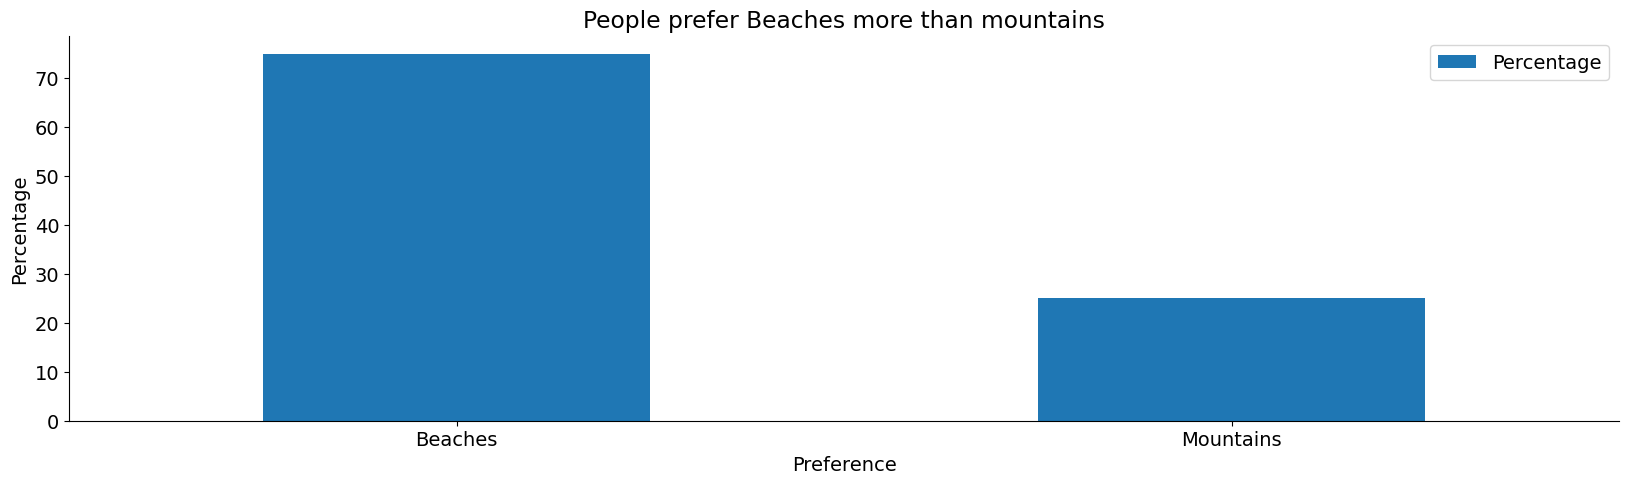

In [ ]:
#calculates the percentage of people who prefer each type of destination and orders the results from the highest to lowest preference

query = '''
select Preference,
       round(count(*)*100.0/(select count(*) from travels),2) as Percentage
from travels
group by 1
order by 2 desc
'''

Preference  = pd.read_sql(query, conn)
Preference.set_index('Preference').plot(kind='bar')
plt.xticks(rotation=0)
plt.title('People prefer Beaches more than mountains')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

**Observation**

74.93% of customers prefer beach destinations, whereas only 25.07% prefer mountains meaning 3 out of 4 people prefers beach destinations.

In [ ]:
query = '''
select Preference,
    ROUND(AVG(Vacation_Budget), 2) as Avg_Budget
from travels
group by 1
order by 2 desc
'''

Vacation_Budget = pd.read_sql(query, conn)
Vacation_Budget

,Preference,Avg_Budget
0,Beaches,2745.37
1,Mountains,2731.14


**Observation:**

The average budget for beach travelers is USD 2,745.37, while for mountain travelers, it is USD 2,731.14.

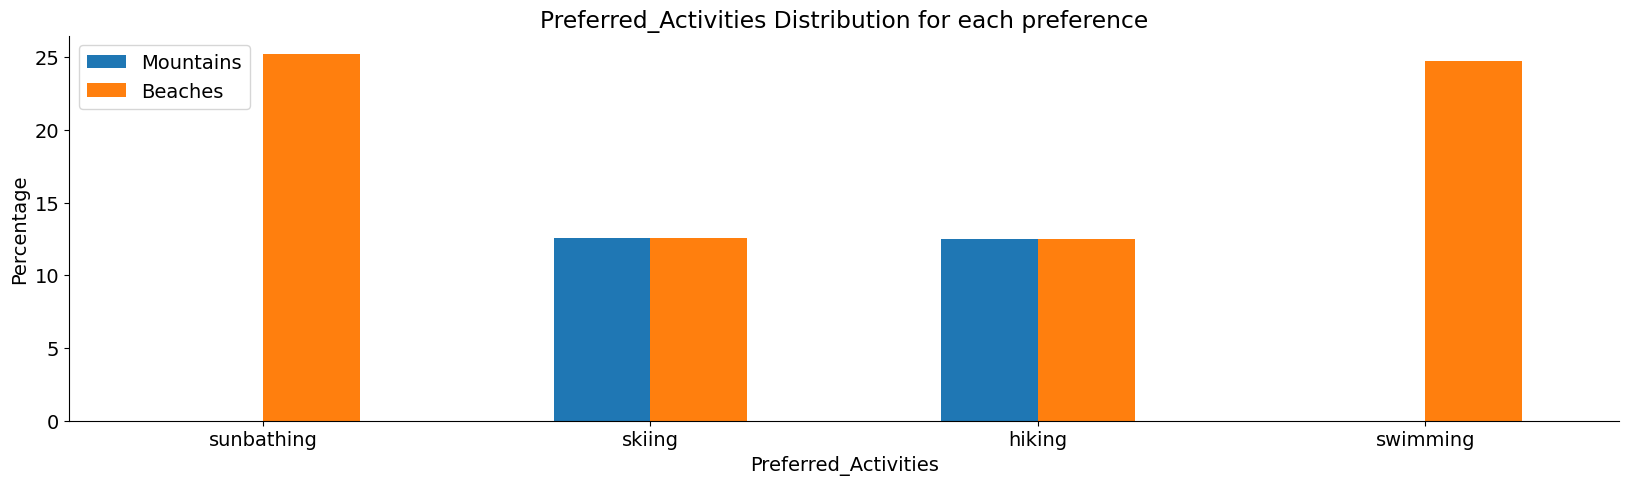

In [ ]:
query = '''
select Preferred_Activities,
    ROUND(SUM(CASE WHEN Preference='Mountains' THEN 1 ELSE 0 END) * 100.0 / (SELECT COUNT(*) FROM travels), 2) AS Mountains,
    ROUND(SUM(CASE WHEN Preference='Beaches' THEN 1 ELSE 0 END) * 100.0 / (SELECT COUNT(*) FROM travels), 2) AS Beaches,
    ROUND(SUM(CASE WHEN Preference IS NOT NULL THEN 1 ELSE 0 END) * 100.0 / (SELECT COUNT(*) FROM travels), 2) AS Total
FROM travels
GROUP BY Preferred_Activities
ORDER BY Total DESC
'''

Preferred_Activities = pd.read_sql(query, conn)
Preferred_Activities.set_index('Preferred_Activities')[['Mountains', 'Beaches']].plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Preferred_Activities Distribution for each preference')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

**Observations**

Sunbathing and Swimming: Predominantly preferred by beachgoers, with almost no interest shown in mountains for these activities.

Skiing and Hiking: Popular among those interested in both mountains and beaches, with slightly more preference from mountain enthusiasts.

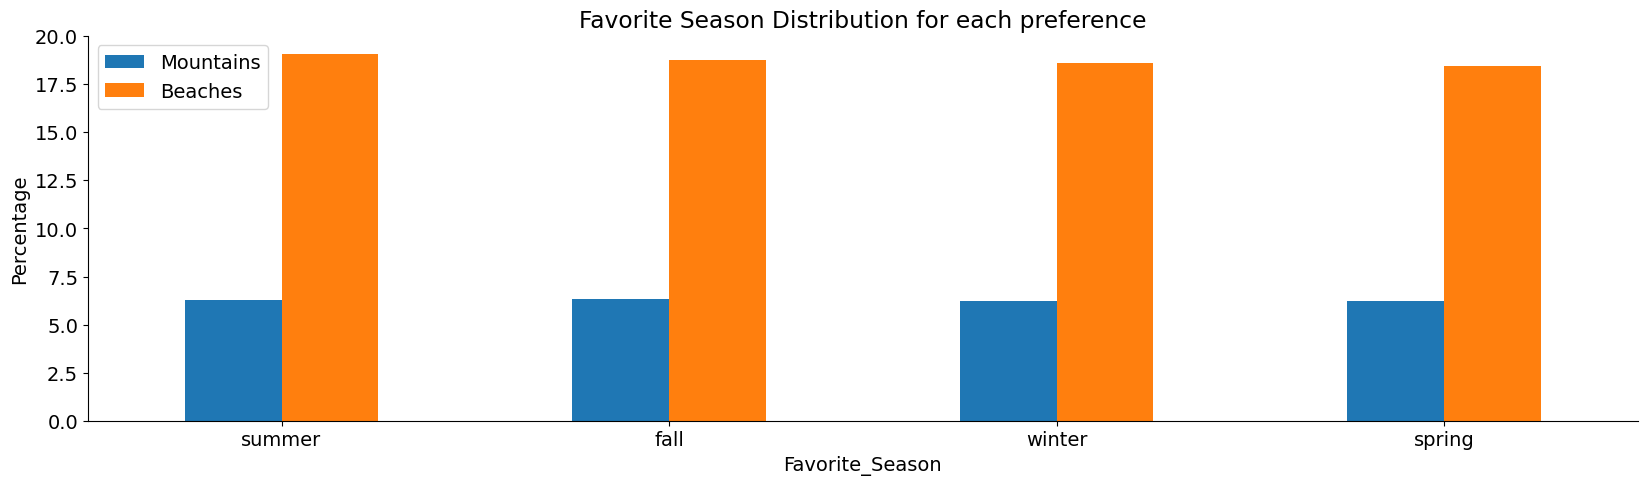

In [ ]:
query = '''
SELECT Favorite_Season,
    ROUND(SUM(CASE WHEN Preference='Mountains' THEN 1 ELSE 0 END) * 100.0 / (SELECT COUNT(*) FROM travels), 2) as Mountains,
    ROUND(SUM(CASE WHEN Preference='Beaches' THEN 1 ELSE 0 END) * 100.0 / (SELECT COUNT(*) FROM travels), 2) as Beaches,
    ROUND(SUM(CASE WHEN Preference IS NOT NULL THEN 1 ELSE 0 END) * 100.0 / (SELECT COUNT(*) FROM travels), 2) as Total
FROM travels
GROUP BY Favorite_Season
ORDER BY Total desc
'''

Favorite_Season = pd.read_sql(query, conn)
Favorite_Season.set_index('Favorite_Season')[['Mountains', 'Beaches']].plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Favorite Season Distribution for each preference')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

**Observations**

Summer and Fall Preference: These seasons are the most popular for beach trips, showing slightly higher interest among beachgoers.

Minimal Seasonal Variation: Preference across seasons for both mountains and beaches remains fairly consistent, with only slight differences in popularity across summer, fall, winter, and spring.

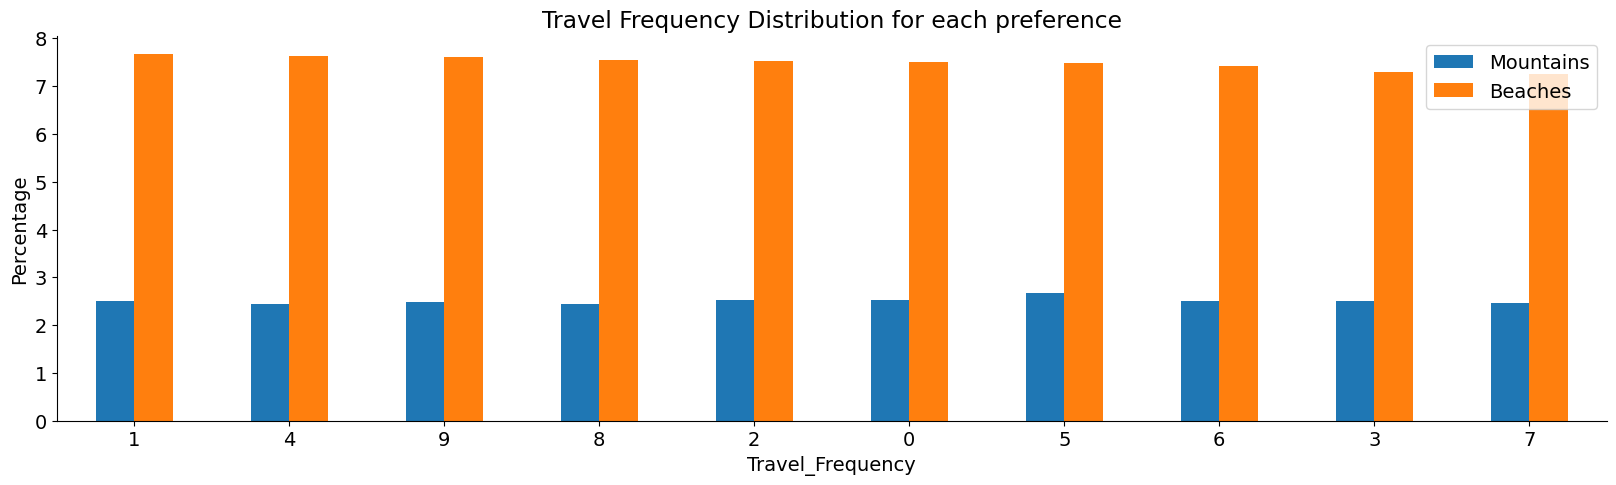

In [ ]:
query = '''
SELECT Travel_Frequency,
    ROUND(SUM(CASE WHEN Preference='Mountains' THEN 1 ELSE 0 END) * 100.0 / (SELECT COUNT(*) FROM travels), 2) as Mountains,
    ROUND(SUM(CASE WHEN Preference='Beaches' THEN 1 ELSE 0 END) * 100.0 / (SELECT COUNT(*) FROM travels), 2) as Beaches,
    ROUND(SUM(CASE WHEN Preference IS NOT NULL THEN 1 ELSE 0 END)*100.0/(select count(*) from travels),2) as Total
FROM travels
GROUP BY Travel_Frequency
ORDER BY Beaches desc
'''

Travel_Frequency = pd.read_sql(query, conn)
Travel_Frequency.set_index('Travel_Frequency')[['Mountains', 'Beaches']].plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Travel Frequency Distribution for each preference')
plt.ylabel('Percentage')
plt.show()

**Observations**

Individuals show a consistent preference for beaches over mountains across all levels of travel frequency.

Individuals with moderate travel frequency (e.g., frequency “5”) show a small peak in interest for mountain destinations, with a higher-than-average percentage (2.68%).

In [ ]:
# in contingency table, one data set is populated in rows while other dataset is columns, to see whether or not two sets are correlated
contingency_table = pd.crosstab(df['Proximity_to_Mountains_Cat'], df['Preference'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-Value: {p:.2e}")
print("Degrees of Freedom:", dof)

if p < 0.05:
    print("There is a statistically significant association between mountain proximity and preference.")
else:
    print("There is no statistically significant association between mountain proximity and preference.")

Chi-Square Statistic: 5398.66
P-Value: 0.00e+00
Degrees of Freedom: 3
There is a statistically significant association between mountain proximity and preference.


In [ ]:
contingency_table = pd.crosstab(df['Proximity_to_Beaches_Cat'], df['Preference'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display results
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-Value: {p:.2e}")
print("Degrees of Freedom:", dof)


# Interpretation based on p-value
if p < 0.05:
    print("There is a statistically significant association between beach proximity and preference.")
else:
    print("There is no statistically significant association between beach proximity and preference.")

Chi-Square Statistic: 5432.00
P-Value: 0.00e+00
Degrees of Freedom: 3
There is a statistically significant association between beach proximity and preference.


In [ ]:
cat_cols = list(filter(lambda x: x != 'Preference', list(df.select_dtypes(['object', 'category']).columns))) + ['Travel_Frequency']
sig_cols = [] # store columns with statistically significant association with preference
insig_cols = [] # store columns without association

for col in cat_cols:
    contingency_table = pd.crosstab(df[col], df['Preference'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    #Interpretation based on the p value
    if p < 0.05:
        sig_cols.append(col)
        print(f"Statistically significant Column : {col}\n")
    else:
        insig_cols.append(col)

Statistically significant Column : Preferred_Activities

Statistically significant Column : Pets

Statistically significant Column : Proximity_to_Mountains_Cat

Statistically significant Column : Proximity_to_Beaches_Cat



**INSIGHTS FROM THE CHI-SQUARE TEST**

Preferred Activities -> significiant association between preferred activities and vacation preferences

Pets -> pet ownership influences vacation preferences

Proximity to Mountains -> living closer to mountains influences preference

Proximity to Beaches -> proximity to beaches affects preferences

In [ ]:
#statistically significant categorical columns
sig_df = df[sig_cols + ['Preference']]
sig_df.head()

,Preferred_Activities,Pets,Proximity_to_Mountains_Cat,Proximity_to_Beaches_Cat,Preference
0,skiing,No,Far,Moderate,Mountains
1,swimming,No,Moderate,Moderate,Beaches
2,skiing,No,Far,Close,Mountains
3,hiking,Yes,Far,Very Close,Mountains
4,sunbathing,Yes,Moderate,Very Close,Beaches


In [ ]:
#statistically insignificant categorical columns
insig_df = df[insig_cols + ['Preference']]
insig_df.head()

,Gender,Education_Level,Location,Favorite_Season,Environmental_Concerns,Age_Cat,Travel_Frequency,Preference
0,male,bachelor,urban,summer,Yes,45-59,9,Mountains
1,male,master,suburban,fall,Yes,60+,1,Beaches
2,female,master,urban,winter,No,45-59,0,Mountains
3,non-binary,high school,rural,summer,No,30-44,6,Mountains
4,female,high school,suburban,winter,Yes,60+,5,Beaches


**Insights Summary**

High Beach Preference: 74.93% of customers favor beach destinations, indicating a strong preference for beach-related activities over mountain-based options.

Higher Budget for Beachgoers: Beach travelers exhibit a slightly higher average budget, suggesting a potential willingness to spend more on amenities and exclusive experiences compared to mountain travelers.

Distinct Activity Preferences: Activities like sunbathing and swimming are highly preferred by beachgoers, whereas skiing and hiking have crossover appeal among both mountain and beach enthusiasts.

Minimal Seasonal Impact on Preferences: Preference for beaches remains strong across all seasons, with slight variations, while mountain preferences show minimal seasonality.

Travel Frequency and Destination Interest: Beach preference remains high across all travel frequencies, while moderate-frequency travelers (frequency level “5”) show a slightly higher inclination toward mountain destinations.

Proximity to Destinations: Customers’ preferences are significantly influenced by proximity to mountains or beaches, indicating a correlation between residential location and vacation destination choice.

Significant Demographic Associations: Certain demographic factors, such as preferred activities and pet ownership, show significant associations with destination preferences, while others, like gender and education, do